**HUMAN ACTIVITY RECOGNITION USING BI-LSTM ON TIME SERIES DATA**

In [2]:
#MOUNTING MY GDRIVE

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#CHECKING FOR GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
# Install libraries by uncommenting if needed

#!pip install tensorflow
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install h5py
#!pip install scikit-learn


In [5]:
#necessary imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import glob
from sklearn.preprocessing import RobustScaler
from scipy import stats
import numpy as np
import h5py
import tensorflow as tf
from tensorflow import keras

 DATA PREPROCESSING

In [6]:
"""
This function takes x & y as the inputs and extrapolates the y to match all the dimensions of the data
It first reads all the csv files and creates a new pandas data frame for the y files with dimension
4 * dimension(y).
All the outliers in the x data are discarded to ensure the dimensions of x & y are same.

Arguments:
    1. x_files: IMU sensor readings
    2. y_files: output label corresponding to each x
 """
def modify_raw_data(x_input, y_input):
    df_y = pd.read_csv(y_input)
    df_x = pd.read_csv(x_input)
    
    new_y = []
    for i in df_y.iterrows():
        new_y += [i[1][0]] * 4
    
    new_y = pd.DataFrame(new_y)
    diff = df_x.shape[0] - new_y.shape[0]
    df_x = df_x.iloc[:-diff,:]
    
    return df_x, new_y

In [7]:
"""
This Scaler removes the median and scales the data according to the quantile range.
The data is standardised by removing the mean and scaling it to unit variance.
This module basically normalizes the data making it robust to variations.
"""
def scale(scaled_data, scale_columns):
    scaler = RobustScaler()
    scaler = scaler.fit(scaled_data[scale_columns].values)
    scaled_data.loc[:, scale_columns] = scaler.transform(scaled_data[scale_columns].to_numpy())
    return scaled_data

In [8]:
STEP = 60
COUNT = 1

In [9]:
"""Takes in X and y data and creates windows of time-series
"""
def create_mode_dataset(X, y, step=1, count=1):
    Xs, ys = [], []
    for i in range(0, len(X) - step, count):
        v = X.iloc[i:(i + step)].values
        labels = y.iloc[i: i + step]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [10]:
def create_dataset(X, label, step = 40, count = 1):
    Xs, ys = [], []
    for i in range(0, len(X) - step, count):
        v = X.iloc[i:(i + step)].values
        Xs.append(v)        
        ys.append(label)
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [11]:
"""
This module takes  balanced x & y data files and creates windowed training instances suitable for the model chosen.
First takes the x & y files, creates balanced data with same dimensions and then creates windows from x and y data.

Arguments:
    1. x_files: x sensor data csv
    2. y_files: y label corresponding to each data csv
    3. time_steps: defines the window size. maximum labels (mode) for a window is kept as the
        output label for that windowed training instance
    4. step: defines the instances to skip before starting the next window
    
    Returns:
    1. stacked windowed training instances from all the files 
        (Dimension = [total-windows] X [time-steps] X [6])
    2. stacked y labels for the corresponding above windowed training instances
        (Dimension = [total-windows] X [1])
"""

def Merge_Data(x_files, y_files, step = 40, count = 1):
    all_x = []
    all_y = []
    for i in range(len(y_files)):
        X, y = modify_raw_data(x_files[i], y_files[i])
        
        X = scale(X, list(X.columns.values))
        X, y = create_mode_dataset(X, y, step = step, count = count)
        
        all_x.append(X)
        all_y.append(y)
    return np.concatenate(all_x), np.concatenate(all_y)

DATA PREPROCESSING

--> Split the data into train test and validation files seperately

--> Creating windowed time-series dataset

In [12]:
cd '/content/gdrive/MyDrive/TerrainRecog/TrainingData'

/content/gdrive/MyDrive/TerrainRecog/TrainingData


In [13]:
all_y_files = sorted(glob.glob('/content/gdrive/MyDrive/TerrainRecog/TrainingData/subject_???_??__y.csv'))
all_x_files = sorted(glob.glob('/content/gdrive/MyDrive/TerrainRecog/TrainingData/subject_???_??__x.csv'))

test_y_files = ["/content/gdrive/MyDrive/TerrainRecog/TrainingData/subject_002_03__y.csv", "/content/gdrive/MyDrive/TerrainRecog/TrainingData/subject_001_04__y.csv"]
test_x_files = ["/content/gdrive/MyDrive/TerrainRecog/TrainingData/subject_002_03__x.csv", "/content/gdrive/MyDrive/TerrainRecog/TrainingData/subject_001_04__x.csv"]

val_y_files = ["/content/gdrive/MyDrive/TerrainRecog/TrainingData/subject_003_02__y.csv", "/content/gdrive/MyDrive/TerrainRecog/TrainingData/subject_007_04__y.csv"]
val_x_files = ["/content/gdrive/MyDrive/TerrainRecog/TrainingData/subject_003_02__x.csv", "/content/gdrive/MyDrive/TerrainRecog/TrainingData/subject_007_04__x.csv"]

# subtract the files that are in test and val
train_y_files = sorted(list(set(all_y_files) ^ set(test_y_files + val_y_files)))
train_x_files = sorted(list(set(all_x_files) ^ set(test_x_files + val_x_files)))

In [14]:
X_train, y_train = Merge_Data(train_x_files, train_y_files, step = STEP, count = COUNT)
X_val, y_val = Merge_Data(val_x_files, val_y_files, step = STEP, count = COUNT)
X_test, y_test = Merge_Data(test_x_files, test_y_files, step = STEP, count = COUNT)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1149648, 60, 6) (1149648, 1)
(86524, 60, 6) (86524, 1)
(103624, 60, 6) (103624, 1)


In [15]:
"""
This module calculates the class weights for each of the 4 output classes in Y data since the data is not balanced.
This information is then passed to the model, to upsample more data from the under represented classes during the training.
this ensure that there is no overfitting.
"""

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(y_train),
                                                 y=y_train.ravel())
print(class_weights)
class_weights = {i:class_weights[i] for i in range(len(class_weights))}
class_weights

[0.33436796 6.24225181 4.4045116  1.60760251]


{0: 0.334367961580701,
 1: 6.242251808092435,
 2: 4.404511600821405,
 3: 1.6076025125431388}

CONVERT THE INPUT LABELS TO ONE-HOT ENCODING

In [16]:

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)
y_val = enc.transform(y_val)

BI-LSTM MODEL

In [17]:
model_save_dir = "final_models"
model_name = "model_BiLSTM_ts%d_s%d"%(STEP, COUNT)

In [18]:
#model structure

model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [19]:
#training using early stopping to prevent over fitting

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_val,y_val),
    class_weight=class_weights,
    shuffle=True
)

Epoch 1/10
8982/8982 [==============================] - 302s 33ms/step - loss: 0.1567 - acc: 0.9080 - val_loss: 0.2698 - val_acc: 0.9139
Epoch 2/10
8982/8982 [==============================] - 291s 32ms/step - loss: 0.0649 - acc: 0.9589 - val_loss: 0.1768 - val_acc: 0.9409
Epoch 3/10
8982/8982 [==============================] - 293s 33ms/step - loss: 0.0445 - acc: 0.9712 - val_loss: 0.2719 - val_acc: 0.9334
Epoch 4/10
8982/8982 [==============================] - 290s 32ms/step - loss: 0.0343 - acc: 0.9782 - val_loss: 0.2122 - val_acc: 0.9471
Epoch 5/10
8982/8982 [==============================] - 290s 32ms/step - loss: 0.0274 - acc: 0.9824 - val_loss: 0.2142 - val_acc: 0.9448
Epoch 6/10
8982/8982 [==============================] - 288s 32ms/step - loss: 0.0236 - acc: 0.9852 - val_loss: 0.1889 - val_acc: 0.9566
Epoch 7/10
8982/8982 [==============================] - 282s 31ms/step - loss: 0.0203 - acc: 0.9876 - val_loss: 0.2589 - val_acc: 0.9448
Epoch 8/10
8982/8982 [===================

MODEL EVALUATION ON THE TEST DATA

In [20]:
model.evaluate(X_test,y_test)

3239/3239 [==============================] - 43s 13ms/step - loss: 0.3835 - acc: 0.9385


[0.3835175633430481, 0.9385470747947693]

In [21]:
y_pred = model.predict(X_test)

In [22]:
from sklearn.metrics import classification_report
from  sklearn.metrics import precision_recall_fscore_support
print(classification_report(enc.inverse_transform(y_test), enc.inverse_transform(y_pred)))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     75760
           1       0.93      0.92      0.93      6134
           2       0.95      0.89      0.92      5506
           3       0.88      0.83      0.85     16224

    accuracy                           0.94    103624
   macro avg       0.93      0.90      0.91    103624
weighted avg       0.94      0.94      0.94    103624



PLOTTING THE GRAPHS

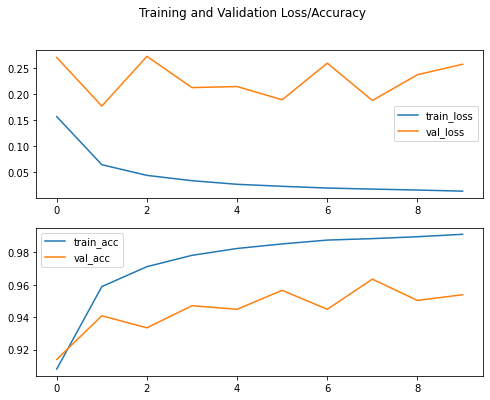

In [23]:
## Plots for Training and Validation

fig, axs = plt.subplots(2)
fig.suptitle('Training and Validation Loss/Accuracy')
axs[0].plot(history.history['loss'], label='train_loss')
axs[0].plot(history.history['val_loss'], label='val_loss')

axs[1].plot(history.history['acc'], label='train_acc')
axs[1].plot(history.history['val_acc'], label='val_acc')

axs[0].legend()
axs[1].legend()
fig.set_size_inches(8,6)

TO GENERATE THE PREDICTION FILES ACCORDING TO THE FORMAT

In [24]:
files=sorted(glob.glob('/content/gdrive/MyDrive/TerrainRecog/TestData/subject_???_??__x.csv'))
files

y_files=sorted(glob.glob('/content/gdrive/MyDrive/TerrainRecog/TestData/subject_???_??__y_time.csv'))
print(files,y_files)

['/content/gdrive/MyDrive/TerrainRecog/TestData/subject_009_01__x.csv', '/content/gdrive/MyDrive/TerrainRecog/TestData/subject_010_01__x.csv', '/content/gdrive/MyDrive/TerrainRecog/TestData/subject_011_01__x.csv', '/content/gdrive/MyDrive/TerrainRecog/TestData/subject_012_01__x.csv'] ['/content/gdrive/MyDrive/TerrainRecog/TestData/subject_009_01__y_time.csv', '/content/gdrive/MyDrive/TerrainRecog/TestData/subject_010_01__y_time.csv', '/content/gdrive/MyDrive/TerrainRecog/TestData/subject_011_01__y_time.csv', '/content/gdrive/MyDrive/TerrainRecog/TestData/subject_012_01__y_time.csv']


In [25]:
def majority_vote(y):
    y_out = []
    for i in range(0, y.shape[0], 4):
        a = list(y[i:i+4])
        y_out.append(max(a, key=a.count))
    return np.array(y_out)

In [27]:
predictions_dir = "./"
TEST_STEP = STEP
TEST_COUNT = 1

In [28]:
to_save_filenames = ["subject_009_01__y_prediction.csv", "subject_010_01__y_prediction.csv", "subject_011_01__y_prediction.csv", "subject_012_01__y_prediction.csv"]

for i in range(len(files)):
    # read x values
    df = pd.read_csv(files[i],header=None)
    # scale x values
    df = scale(df, list(df.columns.values))
    # read y values
    y_df = pd.read_csv(y_files[i],header=None)
    print(y_df.shape)
    
    # pad x values according to the expected y values
    to_add = y_df.shape[0] * 4 - df.shape[0] + STEP
    to_add_df = pd.DataFrame(df.iloc[-to_add:])
    df = df.append(to_add_df)
    
    # create windowed dataset
    X_test, y_test = create_dataset(df, 0, TEST_STEP, TEST_COUNT)
    
    # run model
    y_test = model.predict(X_test)
    
    # convert one-hot to integer class labels
    y_test_int = np.argmax(y_test, axis=1)
    
    # reduce the class size by a factor of 4 by taking majority vote
    # from a window of 4 elements
    y_actual = majority_vote(y_test_int)
    
    print(y_actual.size)
    
    # convert into series to export to csv
    y_series = pd.Series(y_actual)
    y_series.to_csv(predictions_dir + "/" + to_save_filenames[i])

(9498, 1)
9498
(12270, 1)
12270
(12940, 1)
12940
(11330, 1)
11330
